# SimSiam + RetinaNet ResNet18

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import CocoDetection
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models._utils import IntermediateLayerGetter
import torchvision.models as tv_models
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tqdm import tqdm

In [1]:
!pip install pycocotools

In [2]:
!pip install yoco

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 28.4 MB/s eta 0:00:00


## Converstion

In [3]:
import os, json
from tqdm import tqdm
from PIL import Image

def yolo_to_coco(yolo_dir, output_json_path):
    image_dir = os.path.join(yolo_dir, 'images')
    label_dir = os.path.join(yolo_dir, 'labels')
    images = []
    annotations = []
    ann_id = 0
    image_id = 0
    categories = [{'id': 1, 'name': 'vehicle'}]

    for img_name in tqdm(sorted(os.listdir(image_dir))):
        if not img_name.endswith(('.jpg', '.png', '.jpeg')):
            continue

        img_path = os.path.join(image_dir, img_name)
        label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')
        if not os.path.exists(label_path):
            continue

        img = Image.open(img_path)
        w, h = img.size
        images.append({'id': image_id, 'width': w, 'height': h, 'file_name': img_name})

        with open(label_path, 'r') as f:
            for line in f:
                cls, xc, yc, bw, bh = map(float, line.strip().split())
                x = (xc - bw / 2) * w
                y = (yc - bh / 2) * h
                box_w = bw * w
                box_h = bh * h
                if box_w <= 0 or box_h <= 0: continue
                annotations.append({
                    'id': ann_id,
                    'image_id': image_id,
                    'category_id': 1,
                    'bbox': [x, y, box_w, box_h],
                    'area': box_w * box_h,
                    'iscrowd': 0
                })
                ann_id += 1
        image_id += 1

    coco_dict = {
        'images': images,
        'annotations': annotations,
        'categories': categories
    }

    with open(output_json_path, 'w') as f:
        json.dump(coco_dict, f)

# Convert train and valid sets
yolo_to_coco('/kaggle/input/traffic-dataset/traffic_wala_dataset/train', 'train_coco.json')
yolo_to_coco('/kaggle/input/traffic-dataset/traffic_wala_dataset/valid', 'valid_coco.json')


100%|██████████| 90/90 [00:01<00:00, 58.10it/s]


In [1]:
!pip install lightly --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 855.8/855.8 kB 14.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.2 MB/s eta 0:00:00:00:0100:01


In [2]:
import glob

# Define image paths
train_images = glob.glob("/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images/*.jpg")
val_images = glob.glob("/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images/*.jpg")

all_images = train_images + val_images
print(f"Total images available for SSVL pretraining: {len(all_images)}")


Total images available for SSVL pretraining: 626


## Simsiam creation

In [3]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import random

class SimSiamTrafficDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter()], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
        ])

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(img), self.transform(img)  # two views

    def __len__(self):
        return len(self.image_paths)


In [4]:
dataset = SimSiamTrafficDataset(all_images)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

## SimSiam model setup

In [ ]:
import torch.nn as nn
import lightly.models as models
import lightly.loss as loss
import lightly.models.modules.heads as heads
import torchvision.models as tv_models
import torch.nn as nn

class ResNet18Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = tv_models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])  

    def forward(self, x):
        x = self.features(x)           
        return x.view(x.size(0), -1)   

backbone = ResNet18Backbone()

simsiam_model = models.SimSiam(
    backbone,
    num_ftrs=512,            
    proj_hidden_dim=2048,
    pred_hidden_dim=512,
    out_dim=2048
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s] 
/usr/local/lib/python3.11/dist-packages/lightly/models/simsiam.py:65: Warning: The high-level building block SimSiam will be deprecated in version 1.3.0. Use low-level building blocks instead

## Training Simsiam

In [ ]:
import torch
from torch.optim import SGD
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
simsiam_model = simsiam_model.to(device)

criterion = loss.SymNegCosineSimilarityLoss()
optimizer = SGD(simsiam_model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)

epochs = 50  

for epoch in range(epochs):
    total_loss = 0
    simsiam_model.train()
    
    for (x0, x1) in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        x0, x1 = x0.to(device), x1.to(device)
        out0, out1 = simsiam_model(x0, x1)
        loss_val = criterion(out0, out1)
        
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        total_loss += loss_val.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")


/usr/local/lib/python3.11/dist-packages/lightly/loss/sym_neg_cos_sim_loss.py:40: Warning: SymNegCosineSimiliarityLoss will be deprecated in favor of NegativeCosineSimilarity in the future.
  warnings.warn(
Epoch 1/50: 100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Epoch 1, Loss: -0.0340


Epoch 2/50: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]


Epoch 2, Loss: -0.1865


Epoch 3/50: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]


Epoch 3, Loss: -0.4532


Epoch 4/50: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]


Epoch 4, Loss: -0.6634


Epoch 5/50: 100%|██████████| 20/20 [00:03<00:00,  5.59it/s]


Epoch 5, Loss: -0.7612


Epoch 6/50: 100%|██████████| 20/20 [00:03<00:00,  5.82it/s]


Epoch 6, Loss: -0.8037


Epoch 7/50: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Epoch 7, Loss: -0.8364


Epoch 8/50: 100%|██████████| 20/20 [00:03<00:00,  5.61it/s]


Epoch 8, Loss: -0.8502


Epoch 9/50: 100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


Epoch 9, Loss: -0.8686


Epoch 10/50: 100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


Epoch 10, Loss: -0.8822


Epoch 11/50: 100%|██████████| 20/20 [00:03<00:00,  5.57it/s]


Epoch 11, Loss: -0.8939


Epoch 12/50: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]


Epoch 12, Loss: -0.9046


Epoch 13/50: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Epoch 13, Loss: -0.8966


Epoch 14/50: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


Epoch 14, Loss: -0.9094


Epoch 15/50: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Epoch 15, Loss: -0.9036


Epoch 16/50: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Epoch 16, Loss: -0.9114


Epoch 17/50: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Epoch 17, Loss: -0.9144


Epoch 18/50: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Epoch 18, Loss: -0.9230


Epoch 19/50: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch 19, Loss: -0.9228


Epoch 20/50: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Epoch 20, Loss: -0.9303


Epoch 21/50: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]


Epoch 21, Loss: -0.9316


Epoch 22/50: 100%|██████████| 20/20 [00:03<00:00,  5.53it/s]


Epoch 22, Loss: -0.9393


Epoch 23/50: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Epoch 23, Loss: -0.9423


Epoch 24/50: 100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Epoch 24, Loss: -0.9402


Epoch 25/50: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]


Epoch 25, Loss: -0.9421


Epoch 26/50: 100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch 26, Loss: -0.9446


Epoch 27/50: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Epoch 27, Loss: -0.9427


Epoch 28/50: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s]


Epoch 28, Loss: -0.9453


Epoch 29/50: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch 29, Loss: -0.9454


Epoch 30/50: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


Epoch 30, Loss: -0.9475


Epoch 31/50: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]


Epoch 31, Loss: -0.9474


Epoch 32/50: 100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Epoch 32, Loss: -0.9514


Epoch 33/50: 100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Epoch 33, Loss: -0.9523


Epoch 34/50: 100%|██████████| 20/20 [00:03<00:00,  6.00it/s]


Epoch 34, Loss: -0.9491


Epoch 35/50: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Epoch 35, Loss: -0.9513


Epoch 36/50: 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]


Epoch 36, Loss: -0.9524


Epoch 37/50: 100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


Epoch 37, Loss: -0.9574


Epoch 38/50: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Epoch 38, Loss: -0.9518


Epoch 39/50: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]


Epoch 39, Loss: -0.9579


Epoch 40/50: 100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch 40, Loss: -0.9566


Epoch 41/50: 100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch 41, Loss: -0.9551


Epoch 42/50: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Epoch 42, Loss: -0.9560


Epoch 43/50: 100%|██████████| 20/20 [00:03<00:00,  5.87it/s]


Epoch 43, Loss: -0.9568


Epoch 44/50: 100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Epoch 44, Loss: -0.9619


Epoch 45/50: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


Epoch 45, Loss: -0.9623


Epoch 46/50: 100%|██████████| 20/20 [00:03<00:00,  5.82it/s]


Epoch 46, Loss: -0.9588


Epoch 47/50: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Epoch 47, Loss: -0.9607


Epoch 48/50: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]


Epoch 48, Loss: -0.9606


Epoch 49/50: 100%|██████████| 20/20 [00:03<00:00,  5.83it/s]


Epoch 49, Loss: -0.9547


Epoch 50/50: 100%|██████████| 20/20 [00:03<00:00,  5.89it/s]

Epoch 50, Loss: -0.9635


In [ ]:
encoder_state_dict = simsiam_model.backbone.state_dict()
torch.save(encoder_state_dict, "resnet18_simsiam_encoder.pth")


## COCO file create

In [ ]:
import os
import json
from pathlib import Path
from PIL import Image

img_dir = Path("/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images")
label_dir = Path("/kaggle/input/traffic-dataset/traffic_wala_dataset/train/labels")
output_json = "train_coco.json"

coco = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 0, "name": "vehicle"}],
}

ann_id = 1
for img_id, img_file in enumerate(sorted(img_dir.glob("*.jpg"))):
    img = Image.open(img_file)
    width, height = img.size
    img_name = img_file.name
    coco["images"].append({
        "id": img_id,
        "file_name": img_name,
        "width": width,
        "height": height
    })

    
    label_file = label_dir / img_file.with_suffix('.txt').name
    if not label_file.exists():
        continue

    with open(label_file, 'r') as f:
        for line in f:
            cls, x_center, y_center, w, h = map(float, line.strip().split())

            
            x = (x_center - w / 2) * width
            y = (y_center - h / 2) * height
            box_w = w * width
            box_h = h * height

            coco["annotations"].append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": 0,
                "bbox": [x, y, box_w, box_h],
                "area": box_w * box_h,
                "iscrowd": 0
            })
            ann_id += 1

with open(output_json, 'w') as f:
    json.dump(coco, f)


In [ ]:
import os
import json
from pathlib import Path
from PIL import Image

img_dir = Path("/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images")
label_dir = Path("/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels")
output_json = "val_coco.json"

coco = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 0, "name": "vehicle"}],
}

ann_id = 1
for img_id, img_file in enumerate(sorted(img_dir.glob("*.jpg"))):
    img = Image.open(img_file)
    width, height = img.size
    img_name = img_file.name
    coco["images"].append({
        "id": img_id,
        "file_name": img_name,
        "width": width,
        "height": height
    })

    
    label_file = label_dir / img_file.with_suffix('.txt').name
    if not label_file.exists():
        continue

    with open(label_file, 'r') as f:
        for line in f:
            cls, x_center, y_center, w, h = map(float, line.strip().split())

            
            x = (x_center - w / 2) * width
            y = (y_center - h / 2) * height
            box_w = w * width
            box_h = h * height

            coco["annotations"].append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": 0,
                "bbox": [x, y, box_w, box_h],
                "area": box_w * box_h,
                "iscrowd": 0
            })
            ann_id += 1


with open(output_json, 'w') as f:
    json.dump(coco, f)


In [10]:
!pip install -q pycocotools torchvision albumentations

## using the encoder

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as tv_models


class ResNet18Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = tv_models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1]) 

    def forward(self, x):
        x = self.features(x)           
        return x.view(x.size(0), -1)   


model = ResNet18Backbone()

state_dict = torch.load("/kaggle/working/resnet18_simsiam_encoder.pth", map_location="cpu")
model.load_state_dict(state_dict) 


encoder = model


## Freezing

In [ ]:
for param in encoder.parameters():
    param.requires_grad = False


In [ ]:
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.models.detection.backbone_utils import BackboneWithFPN

return_layers = {
    'layer1': '0', 
    'layer2': '1',  
    'layer3': '2',  
    'layer4': '3'   
}
body = IntermediateLayerGetter(tv_models.resnet18(pretrained=True), return_layers=return_layers)

fpn_backbone = BackboneWithFPN(
    backbone=body,
    return_layers=return_layers,
    in_channels_list=[64, 128, 256, 512],
    out_channels=256
)


In [ ]:
from torchvision.models.detection import RetinaNet

model = RetinaNet(
    backbone=fpn_backbone,
    num_classes=2  
)


In [18]:
for param in model.backbone.body.parameters():
    param.requires_grad = False


## Dataset creation

In [ ]:
from torchvision.datasets import CocoDetection
from torchvision import transforms as T
import os

class COCODetectionDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        image_id = self.ids[idx]
        target = {'boxes': [], 'labels': [], 'image_id': image_id}

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        for ann in anns:
            bbox = ann['bbox']  
            x, y, w, h = bbox
            target['boxes'].append([x, y, x + w, y + h])
            target['labels'].append(ann['category_id'])

        target['boxes'] = torch.tensor(target['boxes'], dtype=torch.float32)
        target['labels'] = torch.tensor(target['labels'], dtype=torch.int64)
        target['image_id'] = torch.tensor([image_id])

        if self._transforms:
            img = self._transforms(img)

        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))


In [20]:
transform = T.Compose([
    T.ToTensor()
])

train_dataset = COCODetectionDataset(
    img_folder='/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images',
    ann_file='/kaggle/input/coco-format/train_coco.json',
    transforms=transform
)

val_dataset = COCODetectionDataset(
    img_folder='/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images',
    ann_file='/kaggle/input/coco-format/val_coco.json',
    transforms=transform
)


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [21]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)


## Training

In [22]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    pbar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch}")
    for i, (images, targets) in pbar:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        pbar.set_postfix(loss=losses.item())

@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    total = 0
    pbar = tqdm(data_loader, desc="Evaluating")
    for images, targets in pbar:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)
        total += len(outputs)
    print(f"✅ Evaluation done. Processed {total} images.")


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    evaluate(model, val_loader, device)


torch.save(model.state_dict(), "retinanet_finetuned_ssvl.pth")


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  7.34it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:06<00:00,  7.46it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:06<00:00,  7.46it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:06<00:00,  7.45it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:06<00:00,  7.44it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.52it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.53it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.56it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:06<00:00,  7.49it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.50it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.52it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.53it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.53it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.58it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.56it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.54it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.52it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.55it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.53it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:06<00:00,  7.46it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:06<00:00,  7.47it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.54it/s]


✅ Evaluation done. Processed 90 images.


Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.61it/s]


✅ Evaluation done. Processed 90 images.


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  7.47it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:06<00:00,  7.49it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.59it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.56it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.59it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:06<00:00,  7.49it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.55it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.54it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.56it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.56it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.57it/s]


✅ Evaluation done. Processed 90 images.


Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.55it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.58it/s]


✅ Evaluation done. Processed 90 images.


Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.57it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.57it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.58it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.62it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.56it/s]


✅ Evaluation done. Processed 90 images.


Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.58it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.58it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:06<00:00,  7.48it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.56it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.54it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.50it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:06<00:00,  7.40it/s]


✅ Evaluation done. Processed 90 images.


Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.53it/s]

✅ Evaluation done. Processed 90 images.



Evaluating: 100%|██████████| 45/45 [00:05<00:00,  7.53it/s]

✅ Evaluation done. Processed 90 images.


## Metrics

In [ ]:
with open("val_coco.json", "r") as f:
    coco = json.load(f)
coco["categories"][0]["id"] = 1
for ann in coco["annotations"]:
    ann["category_id"] = 1
with open("val_coco_fixed.json", "w") as f:
    json.dump(coco, f)

class COCODetectionDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms
    def __getitem__(self, idx):
        img, anns = super().__getitem__(idx)
        image_id = self.ids[idx]
        boxes, labels = [], []
        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"]) 
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([image_id])
        }
        if self._transforms:
            img = self._transforms(img)
        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

# Build FPN backbone + RetinaNet
return_layers = {"layer1":"0","layer2":"1","layer3":"2","layer4":"3"}
body = IntermediateLayerGetter(
    tv_models.resnet18(pretrained=False),
    return_layers=return_layers
)
fpn_backbone = BackboneWithFPN(
    backbone=body,
    return_layers=return_layers,
    in_channels_list=[64,128,256,512],
    out_channels=256
)

model = RetinaNet(backbone=fpn_backbone, num_classes=2)  
model.load_state_dict(torch.load("retinanet_finetuned_ssvl.pth", map_location="cpu"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()


transform = T.Compose([T.ToTensor()])
val_ds = COCODetectionDataset(
    img_folder="/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images",
    ann_file="val_coco_fixed.json",
    transforms=transform
)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False,
                        num_workers=4, collate_fn=collate_fn)

predictions = []
with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(tqdm(val_loader, desc="Inferencing")):
        imgs = [img.to(device) for img in images]
        outs = model(imgs)

        
        if batch_idx == 0:
            print("=== Debug: outputs[0] keys and shapes ===")
            for k, v in outs[0].items():
                print(f" {k}: {v.shape}")
            print("========================================")

        for out, tgt in zip(outs, targets):
            img_id = int(tgt["image_id"].item())
            boxes = out["boxes"].cpu().tolist()
            scores = out["scores"].cpu().tolist()
            labels = out["labels"].cpu().tolist()
            for box, score, label in zip(boxes, scores, labels):
                predictions.append({
                    "image_id": img_id,
                    "category_id": label + 1,
                    "bbox": [box[0], box[1], box[2]-box[0], box[3]-box[1]],
                    "score": score
                })

print(f"Total detections collected: {len(predictions)}")
with open("predictions.json", "w") as f:
    json.dump(predictions, f)


if len(predictions) == 0:
    raise RuntimeError("No detections found! Check debug output above to see why `outs` might be empty.")
else:
    coco_gt = COCO("val_coco_fixed.json")
    coco_dt = coco_gt.loadRes("predictions.json")
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Inferencing:   4%|▍         | 2/45 [00:00<00:10,  4.23it/s]

=== Debug: outputs[0] keys and shapes ===
 boxes: torch.Size([51, 4])
 scores: torch.Size([51])
 labels: torch.Size([51])


Inferencing: 100%|██████████| 45/45 [00:05<00:00,  7.53it/s]


Total detections collected: 3138
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.57s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.580
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.915
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.674
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.590
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.446
 Average Recall     (AR) @[ IoU=

## Plot

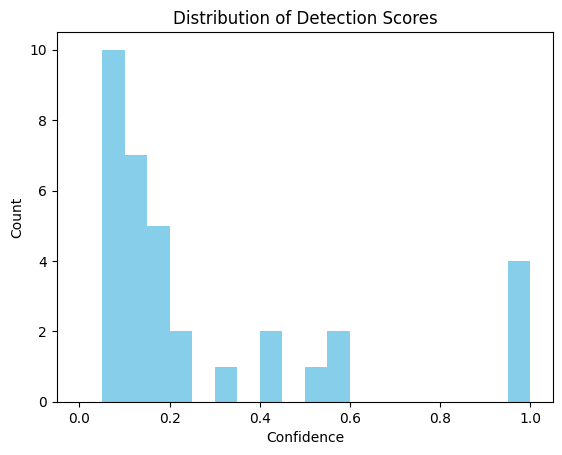

In [ ]:
plt.hist(scores, bins=20, range=(0, 1), color='skyblue')
plt.title("Distribution of Detection Scores")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.show()


In [5]:
colors = {1: 'red', 2: 'blue', 3: 'green'}  # extend as needed
label_names = {1: "Vehicle"}

# In loop:
color = colors.get(label, "white")
name = label_names.get(label, f"Class {label}")
ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                               linewidth=2, edgecolor=color, facecolor="none"))
ax.text(x1, y1 - 10, f"{name} {score:.2f}", color="white",
        fontsize=12, weight="bold",
        bbox=dict(facecolor=color, edgecolor="none", boxstyle="round,pad=0.3"))


Text(708.4714, 600.9456787109375, 'Class 0 0.06')

## Video Testing

In [1]:
import cv2
import torch
from torchvision import transforms as T
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models._utils import IntermediateLayerGetter
import torchvision.models as tv_models
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load RetinaNet model
return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
body = IntermediateLayerGetter(
    tv_models.resnet18(pretrained=False),
    return_layers=return_layers
)
fpn_backbone = BackboneWithFPN(
    backbone=body,
    return_layers=return_layers,
    in_channels_list=[64, 128, 256, 512],
    out_channels=256
)
model = RetinaNet(backbone=fpn_backbone, num_classes=2)
model.load_state_dict(torch.load("/kaggle/input/final-model/pytorch/default/1/retinanet_finetuned_ssvl.pth", map_location=device))
model.to(device).eval()

# Video settings
video_path = "/kaggle/input/vidtryyy/56310-479197605_small.mp4"
cap = cv2.VideoCapture(video_path)

# Save output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_detected.mp4', fourcc, 30.0,
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

# Transform
transform = T.Compose([T.ToTensor()])
threshold = 0.3  # Confidence threshold

# Process video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to tensor
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(rgb_frame)
    input_tensor = transform(pil_img).to(device)

    with torch.no_grad():
        output = model([input_tensor])[0]

    boxes = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()

    # Draw boxes
    for box, score in zip(boxes, scores):
        if score < threshold:
            continue
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame, f"Vehicle {score:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36, 255, 12), 2)

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()
print("✅ Detection complete! Output saved as 'output_detected.mp4'")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Detection complete! Output saved as 'output_detected.mp4'
